In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import KFold


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

SEED=42
cpu=-1
datasetFolder=os.path.dirname(os.path.dirname(os.getcwd()))

def predict_score(model,x_train,y_train,x_test,y_test,name):
    model.fit(x_train,y_train)
    best_pipe=model.best_estimator_
    poly=best_pipe.named_steps["polynomial_features"]
    poly_features=poly.get_feature_names_out(list(x_train.columns))
    selector=best_pipe.named_steps["feature_selection"]
    select_indices=selector.get_support(1)
    select_features=poly_features[select_indices]
    y_predict=model.predict(x_test)
    f1=f1_score(y_test,y_predict)
    auc_score=roc_auc_score(y_test,y_predict)
    a=1
    return f1,auc_score,select_features
    
def baseDataSet(x_train,x_test):
    data=['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x']
    new_x_train=x_train[data]
    new_x_test=x_test[data]
    return new_x_train,new_x_test

def addMetricsDataSet(x_train,x_test):
    data=['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x', 'variablesQty_x', 'parametersQty_x', 'loopQty_x', 'anonymousClassesQty_x', 'innerClassesQty_x', 'ATFD_x', 'ATLD_x', 'LAA_x']
    new_x_train=x_train[data]
    new_x_test=x_test[data]
    return new_x_train,new_x_test


def overSampling(x_train,y_train):
    x_sampling,y_sampling=SMOTE(sampling_strategy=0.2,random_state=SEED).fit_resample(x_train,y_train)
    return x_sampling,y_sampling

In [5]:
FeatureEnvyFile=os.path.join(datasetFolder,"dataset2\\FeatureEnvy.csv")
factors=["fanin_x","fanout_x","wmc_x","loc_x","returnsQty_x","variablesQty_x","parametersQty_x","loopQty_x","anonymousClassesQty_x","innerClassesQty_x","ATFD_x","ATLD_x","LAA_x","FeatureEnvy"]
df=pd.read_csv(FeatureEnvyFile,encoding_errors="replace")
df=df[factors]
df=df.dropna(how="any")
x=df.drop(columns=["FeatureEnvy"])
y=df[["FeatureEnvy"]].values.ravel()
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=SEED)
x_sampling,y_sampling=overSampling(x_train,y_train)

x_base_train,x_base_test=baseDataSet(x_sampling,x_test)
y_base_train=y_sampling
y_base_test=y_test
base_score={"f1":[],"auc":[],"feature":[]}
print(x_base_train.columns)
#x_train_base,y_train_base,x_test_base,y_test_base,features_base=create_train_test_data(x_base,y_base)

x_add_train,x_add_test=addMetricsDataSet(x_sampling,x_test)
y_add_train=y_sampling
y_add_test=y_test
add_score={"f1":[],"auc":[],"feature":[]}
print(x_add_train.columns)
#x_train_add,y_train_add,x_test_add,y_test_add,features_add=create_train_test_data(x_add,y_add)

Index(['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x',
       'variablesQty_x', 'parametersQty_x', 'loopQty_x',
       'anonymousClassesQty_x', 'innerClassesQty_x'],
      dtype='object')
Index(['fanin_x', 'fanout_x', 'wmc_x', 'loc_x', 'returnsQty_x',
       'variablesQty_x', 'parametersQty_x', 'loopQty_x',
       'anonymousClassesQty_x', 'innerClassesQty_x', 'ATFD_x', 'ATLD_x',
       'LAA_x'],
      dtype='object')


In [6]:
from sklearn.ensemble import RandomForestClassifier


name="RF"
RF_prameter={    
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
    }

k_range=np.arange(1,11,1)
for i in k_range:
    pipline=Pipeline([
        ("polynomial_features",PolynomialFeatures(degree=2)),
        ("minmaxscaler",MinMaxScaler()),
        ("feature_selection",SelectKBest(score_func=f_classif,k=i)),
        ("classifier",RandomForestClassifier(random_state=SEED))
    ])
    RF_model=RandomizedSearchCV(pipline, param_distributions=RF_prameter,cv=KFold(n_splits=10,shuffle=True,random_state=SEED),random_state=SEED,n_jobs=cpu,scoring="f1")
    print(str(i))
    f1_base,auc_base,feature_base=predict_score(RF_model,x_base_train,y_base_train,x_base_test,y_base_test,name)
    base_score["f1"].append(f1_base)
    base_score["auc"].append(auc_base)
    base_score["feature"].append(feature_base)
    
    f1_add,auc_add,feature_add=predict_score(RF_model,x_add_train,y_add_train,x_add_test,y_add_test,name)
    add_score["f1"].append(f1_add)
    add_score["auc"].append(auc_add)
    add_score["feature"].append(feature_add)
    

    #features_baselist.append(baseDF.columns[features_base])
    #features_addlist.append(addMetricsDF.columns[features_add])


1


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

2


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

3


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

4


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundati

5


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

6


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

7


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

8


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundati

9


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

10


C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundat

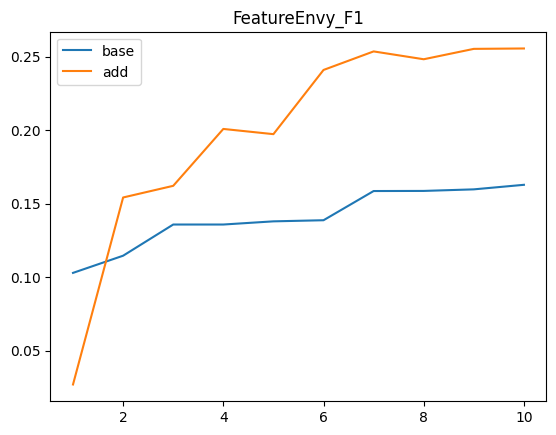

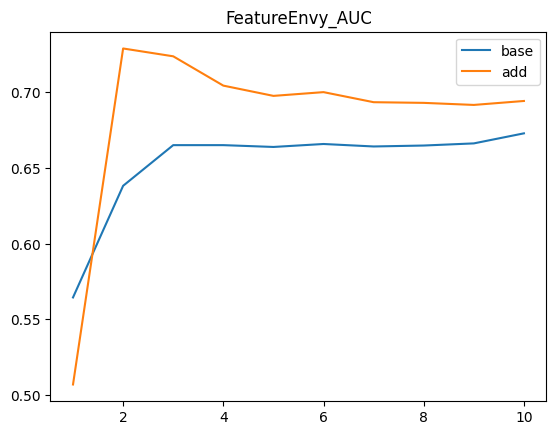

In [7]:
import matplotlib.pyplot as plt

x=k_range
plt.title("FeatureEnvy_F1")
plt.plot(x,base_score["f1"],label="base")
plt.plot(x,add_score["f1"],label="add")
plt.legend()
plt.show()

plt.title("FeatureEnvy_AUC")
plt.plot(x,base_score["auc"],label="base")
plt.plot(x,add_score["auc"],label="add")
plt.legend()
plt.show()

In [8]:
print("base : ",base_score)
print("add : ",add_score)

base :  {'f1': [0.10283517539644402, 0.1145224171539961, 0.13573754069621838, 0.13573754069621838, 0.13789554926678674, 0.1386543873113328, 0.1585180686304282, 0.1585956416464891, 0.15966132446325976, 0.16275616275616275], 'auc': [0.5644586223696133, 0.6381734567678878, 0.6650291712364481, 0.6650291712364481, 0.6638290719083688, 0.6657856281364157, 0.6641507257617644, 0.6647698912270671, 0.6661793255040939, 0.6728212521213877], 'feature': [array(['variablesQty_x'], dtype=object), array(['loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loc_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x'], dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'loc_x parametersQty_x', 'variablesQty_x parametersQty_x'],
      dtype=object), array(['wmc_x', 'loc_x', 'variablesQty_x', 'loopQty_x',
       'fano

In [ ]:
!jupyter nbconvert --to notebook --execute FeatureEnvy_version.ipynb
!jupyter nbconvert --to notebook --execute FeatureEnvy_version1.ipynb
!jupyter nbconvert --to notebook --execute LongMethod_add.ipynb
!jupyter nbconvert --to notebook --execute LongMethod_version.ipynb
!jupyter nbconvert --to notebook --execute LongMethod_version1.ipynb

[NbConvertApp] Converting notebook FeatureEnvy_version.ipynb to notebook
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\zmq\_future.py:718: RuntimeWarning: Proactor event loop does not implement add_reader family of methods required for zmq. Registering an additional selector thread for add_reader support via tornado. Use `asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())` to avoid this warning.
  self._get_loop()
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\syuuj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_sele